# Solving Customer Retention Challenges Using Lifetimes package

## Introduction  

In today's competitive e-commerce landscape, retaining customers is as vital as acquiring new ones. Understanding Customer Lifetime Value (CLV) is key to optimizing retention efforts. CLV estimates the total revenue a customer will generate over their relationship with a business.  

The code below uses Python's lifetimes package to identify high-value customers and predict their future purchasing behavior, informing targeted marketing strategies. Specifically:  
-The BG/NBD model predicts how often a customer will make future purchases.  
-The Gamma-Gamma model estimates how much a customer will spend in those transactions.  

By combining these insights, businesses can prioritize high-value customers and allocate marketing resources effectively, leading to better retention and increased revenue.

In [1]:
#install and import the relevant libraries
!pip install openpyxl
!pip install lifetimes
!pip install xlrd
import pandas as pd
import numpy as np
import datetime as dt
from lifetimes import BetaGeoFitter #Imports the BetaGeoFitter class from the Lifetimes package. This class is used to fit the BG/NBD model, which predicts the probability of repeat purchases for customers over time.
from lifetimes import GammaGammaFitter #Imports the GammaGammaFitter class from the Lifetimes package. This class is used to model customer transaction data to estimate average transaction value or customer profitability.
from sklearn.preprocessing import MinMaxScaler #It is used to scale data features to a specific range, typically between 0 and 1.
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix #Plots the probability of a customer being "alive" (active).
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import random
random.seed(42) #We are setting the seed to assure you get the same answers
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setting the stage: 

### Step 1: Data Preparation
To begin, we load the historical transaction data of an online retail company into a Pandas DataFrame. The dataset contained transactions from 2010 to 2011. The initial steps involved inspecting the data and handling any missing values or outliers. This process ensured that there is a clean dataset to work with, free from null values, which could otherwise skew the analysis.

In [2]:
df = pd.read_excel('link to dataset location/datasetname.csv', sheet_name='Year 2010-2011') #replace this with the link to your dataset location
df_ = df.copy()

In [3]:
def check_df(dataframe):
    print('######Shape######')
    print(dataframe.shape)
    print('######Columns######')
    print(dataframe.columns)
    print('######Datatypes######')
    print(dataframe.dtypes)
    print('######Head######')
    print(dataframe.head())
    print('######Tail######')
    print(dataframe.tail())
    print('######Description######')
    print(dataframe.describe())

check_df(df)

######Shape######
(541910, 8)
######Columns######
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
######Datatypes######
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
######Head######
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate   Price  Customer ID         Country  
0 2010-12-01 08:26:00 2.55000  17850.

In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

### Step 2: Outlier Detection and Correction
Outliers can distort the analysis, particularly in a dataset involving monetary transactions. we implement functions to detect and correct outliers in key variables like Price and Quantity.

In [6]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

### Step 3: Data Segmentation
For this analysis, we focus on customers based in the United Kingdom, as they represented the majority of the business's transactions. We also filter out canceled orders and transactions where prices were zero or negative.

In [7]:
    df_uk = df[df['Country'] == 'United Kingdom']
    f_uk = df_uk[~df_uk['Invoice'].str.contains('C', na=False)]
    df_uk = df_uk[df_uk['Price'] > 0]

In [8]:
replace_with_thresholds(df_uk, 'Price')
replace_with_thresholds(df_uk, 'Quantity')

In [9]:
df_uk.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom


In [10]:
df_uk['TotalPrice'] = df_uk['Quantity'] * df_uk['Price']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom,15.30000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom,22.00000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65000,17850.00000,United Kingdom,15.30000
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25000,17850.00000,United Kingdom,25.50000


### Step 4: Calculating CLV Metrics
With the clean dataset, we calculate the key metrics needed for the CLV model—recency, frequency, and monetary value. Recency and frequency were converted into weekly units to standardize the data.

In [11]:
df_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [12]:
today_date = dt.datetime(2011, 12, 11)

In [13]:
df_uk = df_uk.groupby('Customer ID').agg({'TotalPrice':'sum',
                              'InvoiceDate': [lambda date: (date.max()-date.min()).days,
                                              lambda date: (today_date - date.min()).days],
                              'Invoice': lambda Invoice: Invoice.nunique()})

In [15]:
df_uk.columns.droplevel(0)
df_uk.columns = ['monetary', 'recency', 'T', 'frequency']

In [16]:
df_uk.head()

,monetary,recency,T,frequency
Customer ID,,,,
12346.00000,101.92000,0,326,2
12747.00000,4196.01000,366,370,11
12748.00000,30467.84000,372,374,223
12749.00000,3849.76000,209,214,8
12820.00000,942.34000,323,327,4


In [17]:
df_uk['monetary'] = df_uk['monetary'] / df_uk['frequency'] #average spend per visit
df_uk = df_uk[df_uk['frequency'] > 1] #making sure the customer has purchased with us atleast once
df_uk['recency'] = df_uk['recency'] / 7  #converting the recency in weeks
df_uk['T'] = df_uk['T'] / 7 #converting the total timespan in weeks

## BG/NBD Model

### Step 1: Fitting the model
We apply the Beta Geometric/NBD model (BG/NBD) using the lifetimes package to estimate the probability of repeat purchases for each customer. Using the BG/NBD model, we can predict which customers are most likely to make repeat purchases. Such information can allow marketing teams to focus their efforts on high-value customers, offering them personalized incentives that ultimately improved retention rates. 

The bgf summary values indicate that the model adequately fits the data:
- A value of r around 1.96 is quite common, suggesting a moderate level of over-dispersion in the data. The standard error (se) is relatively small, indicating a stable estimate.
- An alpha of 8.00 suggests that customers have a low probability of making frequent purchases, which might indicate infrequent buying patterns. The standard error here is also small, suggesting a reliable estimate.
- The a parameter being around 0.35 suggests that the average repeat purchase rate is relatively low. The small standard error again suggests a stable estimate.
- A b value of around 6.27 indicates moderate variability in the repeat purchase rate among customers. The standard error is larger compared to the other parameters, but it still provides a reasonable bound.
- The 95% confidence intervals for each parameter (lower 95% bound and upper 95% bound) are all relatively tight, which means that the model is providing stable estimates for these parameters. 

In [19]:
bgf = BetaGeoFitter()
bgf.fit(df_uk['frequency'], df_uk['recency'], df_uk['T'])
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 2762 subjects, a: 0.35, alpha: 8.01, b: 6.27, r: 1.96>

In [21]:
df_uk = df_uk[df_uk['monetary'] > 0]

### Step 2: Visualizing Transaction Frequency
We also plot the distribution of the number of transactions across different time periods. This visualization helps in validating the assumptions of the Beta Geometric/NBD model. The plot provides a visual representation of the model’s accuracy in predicting the number of purchases customers will make in the future. A close alignment between the actual and expected values indicates a good model fit.

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

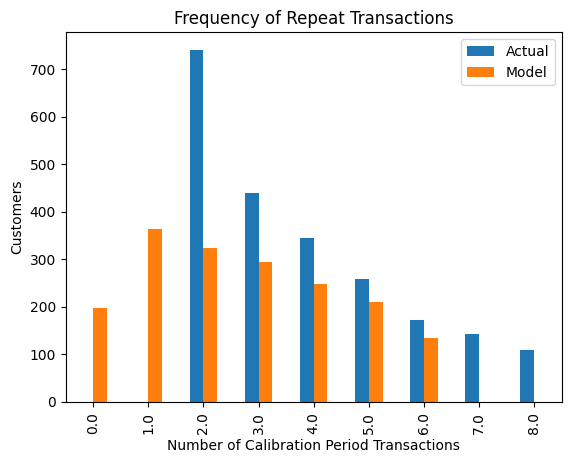

In [22]:
plot_period_transactions(bgf)

### Step 3: Predicting Future Purchases
Using the fitted BG/NBD model, we predict the expected number of purchases each customer would make over the next six months. This prediction is critical for identifying high-value customers who are likely to contribute to future revenue. This step reveals the top customers expected to make the most purchases, providing the marketing team with valuable insights for targeted campaigns.

In [23]:
df_uk['expected_purch_6month'] = bgf.predict(4*6, df_uk['frequency'], df_uk['recency'], df_uk['T'])

In [24]:
df_uk.sort_values(by='expected_purch_6month', ascending= False).head()

,monetary,recency,T,frequency,expected_purch_6month
Customer ID,,,,,
12748.00000,136.62709,53.14286,53.42857,223,82.45133
17841.00000,237.46757,53.00000,53.42857,169,62.53499
14606.00000,90.96586,53.14286,53.42857,128,47.64105
13089.00000,485.68059,52.28571,52.85714,118,44.19619
15311.00000,503.42915,53.28571,53.42857,118,44.02690


## Gamma-Gamma model

### Step 1: Estimating Monetary Value using the Gamma- Gamma model
To further refine our CLV model, we use the Gamma-Gamma (GG) model to estimate the expected average profit from each customer. This model complements the BG/NBD model by predicting the average transaction value, which is essential for calculating the overall CLV. This analysis helps to identify customers who not only make frequent purchases but also contribute significantly to the company's profit margin.

In [25]:
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(df_uk['frequency'], df_uk['monetary'])
    ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.71286,0.08229,2.55157,2.87415
q,0.33083,0.00732,0.31648,0.34518
v,3.66271,0.09958,3.46752,3.85789


In [26]:
ggf.conditional_expected_average_profit(df_uk['frequency'], df_uk['monetary']).sort_values(ascending=False).head(10)

Customer ID
14088.00000   3642.91033
18102.00000   3506.46027
16000.00000   2268.68318
17450.00000   2192.56279
16684.00000   1924.67921
17511.00000   1916.45012
16182.00000   1741.70020
17084.00000   1684.45521
16126.00000   1676.22508
14096.00000   1577.19420
dtype: float64

### Step 2: Calculating Customer Lifetime Value (CLV)
Finally, we calculate the CLV for each customer by combining the purchase frequency and monetary value predictions from the BG/NBD and Gamma-Gamma models. The CLV provides a holistic view of each customer's value to the business over the next six months.

In [27]:
df_uk['expected_average_profit'] = ggf.conditional_expected_average_profit(df_uk['frequency'], df_uk['monetary'])
cltv = ggf.customer_lifetime_value(bgf, df_uk['frequency'], df_uk['recency'], df_uk['T'], df_uk['monetary'], time=6, freq='W')

In [28]:
cltv = cltv.reset_index()

In [29]:
cltv_final = df_uk.merge(cltv, on='Customer ID', how='left')

In [30]:
cltv_final.sort_values(by='clv', ascending=False).head()

,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv
2648,18102.00000,3492.45081,52.28571,52.57143,62,23.74291,3506.46027,87015.12702
637,14096.00000,1565.64412,13.85714,14.57143,34,32.66895,1577.19420,53660.86730
2332,17450.00000,2182.66291,51.28571,52.57143,55,20.88890,2192.56279,47870.49168
2363,17511.00000,1906.09391,52.85714,53.42857,46,17.52024,1916.45012,35097.02687
1596,16000.00000,2080.92667,0.00000,0.42857,3,10.96741,2268.68318,25845.55543


### Step 3: Scaling and Prioritizing CLV
To assist the marketing team in prioritizing their efforts, we normalize the CLV scores using Min-Max Scaling. This scaling ensures that the CLV values are within a consistent range, making it easier to compare and prioritize customers.

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[['clv']])
cltv_final['scaled_cltv'] = scaler.transform(cltv_final[['clv']])
cltv_final.sort_values(by='scaled_cltv', ascending=False).head()

,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv,scaled_cltv
2648,18102.00000,3492.45081,52.28571,52.57143,62,23.74291,3506.46027,87015.12702,1.00000
637,14096.00000,1565.64412,13.85714,14.57143,34,32.66895,1577.19420,53660.86730,0.61668
2332,17450.00000,2182.66291,51.28571,52.57143,55,20.88890,2192.56279,47870.49168,0.55014
2363,17511.00000,1906.09391,52.85714,53.42857,46,17.52024,1916.45012,35097.02687,0.40334
1596,16000.00000,2080.92667,0.00000,0.42857,3,10.96741,2268.68318,25845.55543,0.29702
